In [17]:
import pyodbc
print(pyodbc.drivers())


['SQL Server', 'SQL Server Native Client RDA 11.0', 'ODBC Driver 17 for SQL Server', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']


In [19]:
!pip install sqlalchemy pyodbc

In [21]:
from sqlalchemy import create_engine
import urllib

params = urllib.parse.quote_plus(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=NIKHIL\\SQLEXPRESS;"
    "Database=salesdb;"
    "Trusted_Connection=yes;"
)

engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)


In [25]:
import pandas as pd

df = pd.read_csv("store_sales_forecasting.csv")
df.head()


,Date,Product_Category,Units_Sold,Daily_Revenue,Demand_Index,Day_of_Week,Is_Weekend,Is_Holiday,Price,Is_On_Sale,Avg_Daily_Temperature,Rainfall_mm
0,2021-01-01,Clothing,64.0,1920.0,61,4,0,1,30.0,0.0,15.755450,1.316793
1,2021-01-01,Household,108.0,1620.0,61,4,0,1,15.0,0.0,15.755450,1.316793
2,2021-01-01,Electronics,37.0,1850.0,61,4,0,1,50.0,0.0,15.755450,1.316793
3,2021-01-02,Clothing,59.0,1770.0,56,5,1,0,30.0,0.0,15.474275,1.503343
4,2021-01-02,Household,99.0,1485.0,56,5,1,0,15.0,0.0,15.474275,1.503343


In [27]:
df['Date'] = pd.to_datetime(df['Date'])
df.columns = [c.strip().replace(" ", "_") for c in df.columns]


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5478 entries, 0 to 5477
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   5478 non-null   datetime64[ns]
 1   Product_Category       5478 non-null   object        
 2   Units_Sold             5451 non-null   float64       
 3   Daily_Revenue          5451 non-null   float64       
 4   Demand_Index           5478 non-null   int64         
 5   Day_of_Week            5478 non-null   int64         
 6   Is_Weekend             5478 non-null   int64         
 7   Is_Holiday             5478 non-null   int64         
 8   Price                  5478 non-null   float64       
 9   Is_On_Sale             5423 non-null   float64       
 10  Avg_Daily_Temperature  5314 non-null   float64       
 11  Rainfall_mm            5204 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(4), object(1)
memory u

In [37]:
df.to_sql(
    "store_sales",
    con=engine,
    if_exists="replace",
    index=False,
    chunksize=100
)


5478

In [117]:
df = pd.read_sql("SELECT * FROM store_sales ORDER BY Date", con=engine)
df.head()


,Date,Product_Category,Units_Sold,Daily_Revenue,Demand_Index,Day_of_Week,Is_Weekend,Is_Holiday,Price,Is_On_Sale,Avg_Daily_Temperature,Rainfall_mm
0,2021-01-01,Clothing,64.0,1920.0,61,4,0,1,30.0,0.0,15.755450,1.316793
1,2021-01-01,Household,108.0,1620.0,61,4,0,1,15.0,0.0,15.755450,1.316793
2,2021-01-01,Electronics,37.0,1850.0,61,4,0,1,50.0,0.0,15.755450,1.316793
3,2021-01-02,Clothing,59.0,1770.0,56,5,1,0,30.0,0.0,15.474275,1.503343
4,2021-01-02,Household,99.0,1485.0,56,5,1,0,15.0,0.0,15.474275,1.503343


In [119]:
print(df.describe())

                      Date   Units_Sold  Daily_Revenue  Demand_Index  \
count                 5478  5451.000000    5451.000000   5478.000000   
mean   2023-07-02 12:00:00    66.027701    1674.473812     54.440854   
min    2021-01-01 00:00:00    14.000000     700.000000     30.000000   
25%    2022-04-02 00:00:00    41.000000    1395.000000     46.000000   
50%    2023-07-02 12:00:00    59.000000    1620.000000     54.000000   
75%    2024-10-01 00:00:00    86.000000    1875.000000     61.000000   
max    2025-12-31 00:00:00   971.000000   17100.000000    100.000000   
std                    NaN    38.530205     661.168446     10.938992   

       Day_of_Week   Is_Weekend   Is_Holiday        Price   Is_On_Sale  \
count   5478.00000  5478.000000  5478.000000  5478.000000  5423.000000   
mean       3.00000     0.285871     0.008215    31.028934     0.134796   
min        0.00000     0.000000     0.000000    12.750000     0.000000   
25%        1.00000     0.000000     0.000000    15.0000

In [121]:
print(df['Product_Category'].unique())

['Clothing' 'Household' 'Electronics']


Data Preprocessing

In [124]:
df.isnull().sum()

Date                       0
Product_Category           0
Units_Sold                27
Daily_Revenue             27
Demand_Index               0
Day_of_Week                0
Is_Weekend                 0
Is_Holiday                 0
Price                      0
Is_On_Sale                55
Avg_Daily_Temperature    164
Rainfall_mm              274
dtype: int64

In [126]:

df['Rainfall_mm'] = df['Rainfall_mm'].fillna(method='ffill')

df['Avg_Daily_Temperature'] = df['Avg_Daily_Temperature'].interpolate(method='linear')

df['Is_On_Sale'] = df['Is_On_Sale'].fillna(0).astype(int)

for category in df['Product_Category'].unique():
    mask = df['Product_Category'] == category
    df.loc[mask, 'Units_Sold'] = df.loc[mask, 'Units_Sold'].astype(float).interpolate(method='linear')

df['Units_Sold'] = df['Units_Sold'].round().astype('Int64')

df['Daily_Revenue'] = (df['Units_Sold'] * df['Price']).round(2)

print(df.isnull().sum().to_markdown())

|                       |   0 |
|:----------------------|----:|
| Date                  |   0 |
| Product_Category      |   0 |
| Units_Sold            |   0 |
| Daily_Revenue         |   0 |
| Demand_Index          |   0 |
| Day_of_Week           |   0 |
| Is_Weekend            |   0 |
| Is_Holiday            |   0 |
| Price                 |   0 |
| Is_On_Sale            |   0 |
| Avg_Daily_Temperature |   0 |
| Rainfall_mm           |   0 |


C:\Users\nikhi\AppData\Local\Temp\ipykernel_8464\703866654.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Rainfall_mm'] = df['Rainfall_mm'].fillna(method='ffill')


In [128]:

category_column = 'Product_Category'
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['Product_Category']=le.fit_transform(df[category_column])
# Perform One-Hot Encoding
# drop_first=True prevents multicollinearity by removing one redundant category column
#df_encoded = pd.get_dummies(df, columns=[category_column], prefix=category_column, drop_first=True)

# Display the result (showing the new columns)
#print(f"Original Columns: {list(df.columns)}")
#print(f"Encoded Columns: {list(df_encoded.columns)}")
#print("\nFirst 5 rows with new encoded columns:")
#print(df_encoded[['Product_Category_Electronics', 'Product_Category_Household', 'Units_Sold']].head().to_markdown(index=False))

# Update the main DataFrame to the encoded version
#df = df_encoded
df.head()
#print("Categorical Encoding Complete. Data is ready for Scaling/Normalization.")

,Date,Product_Category,Units_Sold,Daily_Revenue,Demand_Index,Day_of_Week,Is_Weekend,Is_Holiday,Price,Is_On_Sale,Avg_Daily_Temperature,Rainfall_mm
0,2021-01-01,0,64,1920.0,61,4,0,1,30.0,0,15.755450,1.316793
1,2021-01-01,2,108,1620.0,61,4,0,1,15.0,0,15.755450,1.316793
2,2021-01-01,1,37,1850.0,61,4,0,1,50.0,0,15.755450,1.316793
3,2021-01-02,0,59,1770.0,56,5,1,0,30.0,0,15.474275,1.503343
4,2021-01-02,2,99,1485.0,56,5,1,0,15.0,0,15.474275,1.503343


In [130]:
numerical_cols = [
    'Demand_Index',
    'Price',
    'Avg_Daily_Temperature',
    'Rainfall_mm'
]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("\nSummary Statistics AFTER Scaling (Mean should be ~0, Std Dev should be ~1):")
print(df[numerical_cols].describe().to_markdown())

print("\nScaling/Normalization Complete. Data is ready for Distribution Plots.")


Summary Statistics AFTER Scaling (Mean should be ~0, Std Dev should be ~1):
|       |   Demand_Index |          Price |   Avg_Daily_Temperature |    Rainfall_mm |
|:------|---------------:|---------------:|------------------------:|---------------:|
| count |  5478          | 5478           |          5478           | 5478           |
| mean  |    -2.1791e-16 |   -1.89699e-17 |             1.76403e-16 |   -1.16738e-17 |
| std   |     1.00009    |    1.00009     |             1.00009     |    1.00009     |
| min   |    -2.23449    |   -1.29005     |            -2.10359     |   -0.278933    |
| 25%   |    -0.7717     |   -1.13125     |            -0.918766    |   -0.278933    |
| 50%   |    -0.0403049  |   -0.0726178   |            -0.0185754   |   -0.156796    |
| 75%   |     0.599666   |    1.3389      |             0.921253    |    0.0639396   |
| max   |     4.16522    |    1.3389      |             2.05348     |   38.7084      |

Scaling/Normalization Complete. Data is ready for Di

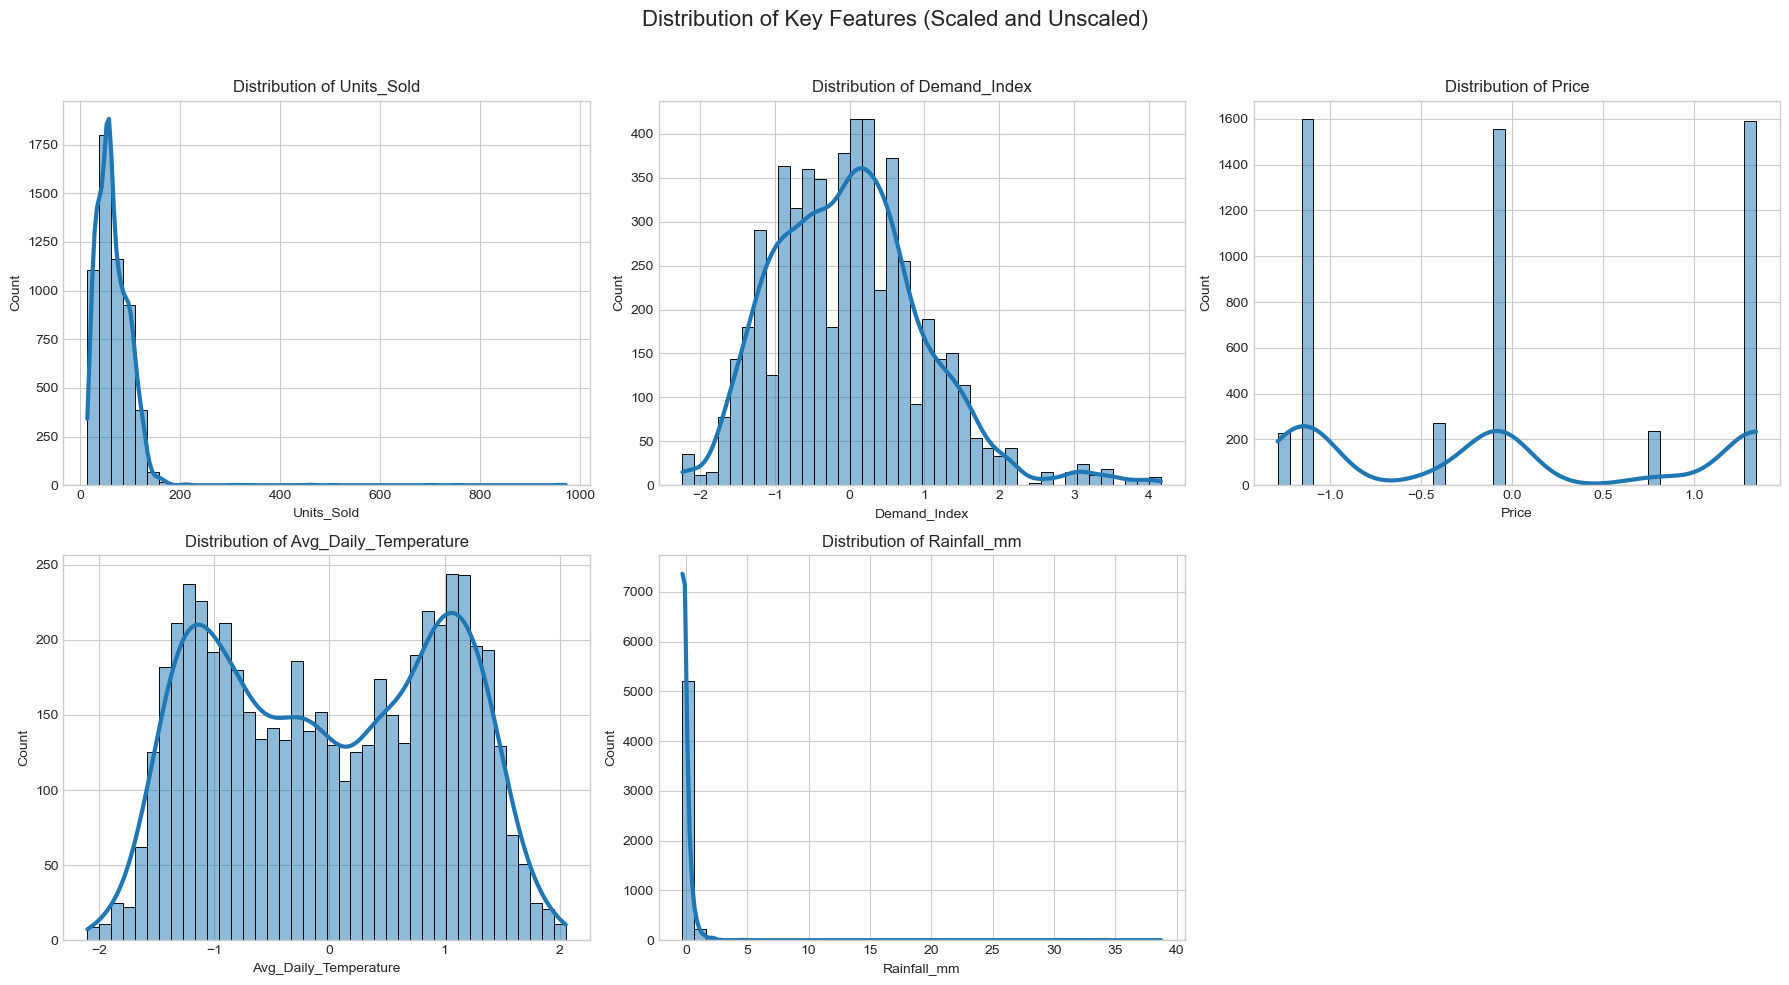

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming 'df' is the cleaned and scaled DataFrame from the previous steps

# Define the numerical columns (scaled and unscaled target)
plot_cols = [
    'Units_Sold',
    'Demand_Index',
    'Price',
    'Avg_Daily_Temperature',
    'Rainfall_mm'
]

# Set up the visualization
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
fig.suptitle('Distribution of Key Features (Scaled and Unscaled)', fontsize=16)

# Loop through columns to create plots
for i, col in enumerate(plot_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=40,
                 line_kws={'linewidth': 3, 'color': 'red'})
    axes[i].set_title(f'Distribution of {col}', fontsize=12)

# Remove the empty subplot
fig.delaxes(axes[5])
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()

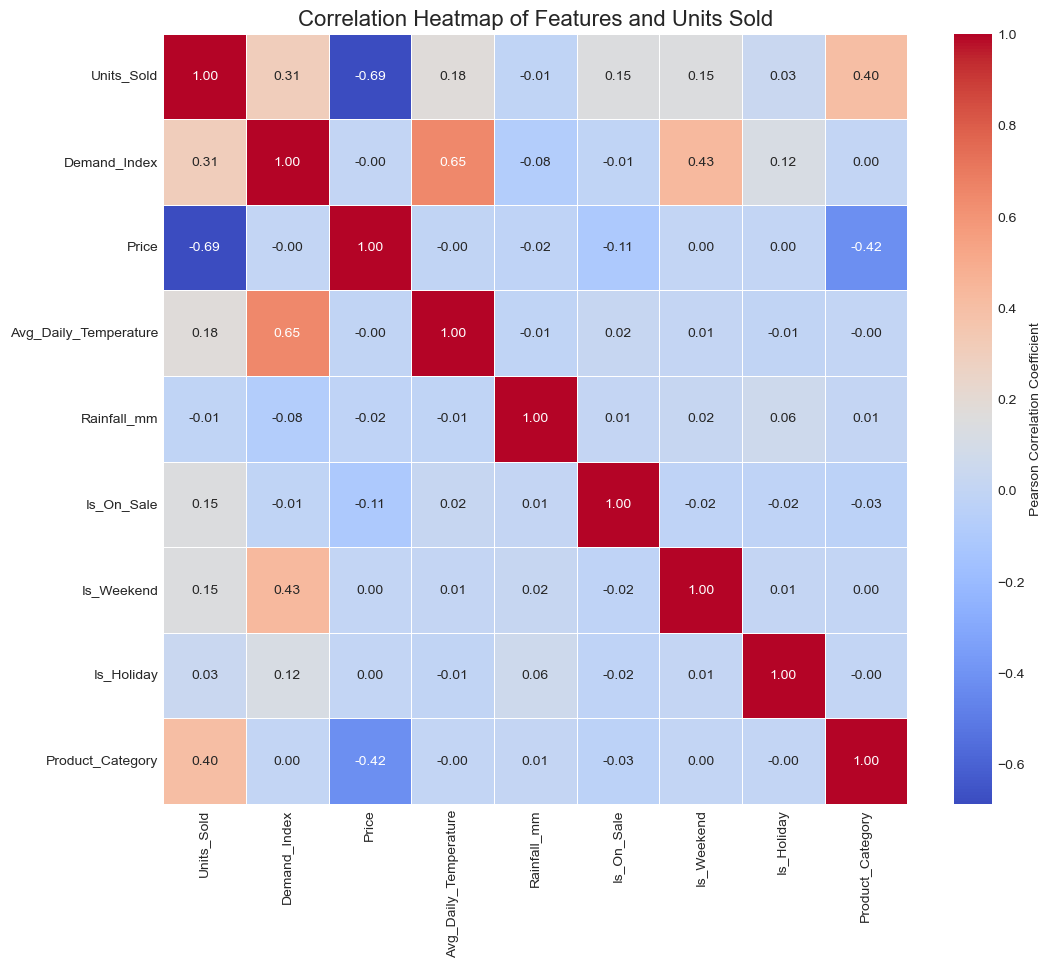

In [134]:
# 1. Select the relevant columns for correlation
# We include the target (Units_Sold), all scaled numerical features,
# and all encoded binary/integer features (including Day_of_Week and Is_Holiday).
correlation_cols = [
    'Units_Sold',
    'Demand_Index',
    'Price',
    'Avg_Daily_Temperature',
    'Rainfall_mm',
    'Is_On_Sale',
    'Is_Weekend',
    'Is_Holiday',
    'Product_Category'
]

df_corr = df[correlation_cols].copy()

# 2. Calculate the correlation matrix
corr_matrix = df_corr.corr()

# 3. Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5,
            cbar_kws={'label': 'Pearson Correlation Coefficient'})
plt.title('Correlation Heatmap of Features and Units Sold', fontsize=16)
plt.show()

In [136]:
# Assuming 'df' is the current, fully prepared DataFrame (imputed, encoded, scaled).

# --- 1. Preparation for Skewness Analysis (Requires Original Values) ---

# NOTE: Skewness must be calculated on UNSEALED data.
# We will reload the base data and apply only imputation for this step's calculation.
df_original_values = pd.read_csv("store_sales_forecasting.csv")
df_original_values['Date'] = pd.to_datetime(df_original_values['Date'])

# Re-apply necessary imputation steps to the unscaled version for correctness
df_original_values['Rainfall_mm'] = df_original_values['Rainfall_mm'].fillna(method='ffill')
df_original_values['Units_Sold'] = df_original_values['Units_Sold'].astype(float).interpolate(method='linear').round().astype('Int64')
# Impute Temp just to clean the data for analysis
df_original_values['Avg_Daily_Temperature'] = df_original_values['Avg_Daily_Temperature'].interpolate(method='linear')


# --- 2. Quantitative Skewness Check ---

print("\n--- A. Skewness of Key Columns (Using Original Values) ---")
# Skewness is a measure of the asymmetry of the probability distribution.
# A value > 1 or < -1 typically indicates significant skewness requiring a transform (like log-transform).

skew_cols = ['Units_Sold', 'Daily_Revenue', 'Rainfall_mm', 'Avg_Daily_Temperature', 'Demand_Index']
skewness = df_original_values[skew_cols].skew().sort_values(ascending=False)

print(skewness.to_markdown())

# --- 3. Quantitative Outlier Check (Using IQR Method) ---

print("\n--- B. Outlier Count (Using 1.5 * IQR on Original Values) ---")
# Outliers are defined here as values outside Q3 + 1.5 * IQR or Q1 - 1.5 * IQR.

outlier_check_cols = ['Units_Sold', 'Rainfall_mm']

for col in outlier_check_cols:
    Q1 = df_original_values[col].quantile(0.25)
    Q3 = df_original_values[col].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate upper and lower bounds
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    # Count outliers
    outlier_count = df_original_values[
        (df_original_values[col] > upper_bound) |
        (df_original_values[col] < lower_bound)
    ].shape[0]

    print(f"- {col}: {outlier_count} rows ({outlier_count / len(df_original_values) * 100:.2f}%)")




--- A. Skewness of Key Columns (Using Original Values) ---
|                       |          0 |
|:----------------------|-----------:|
| Rainfall_mm           | 28.3586    |
| Daily_Revenue         | 12.3006    |
| Units_Sold            |  7.58066   |
| Demand_Index          |  0.67786   |
| Avg_Daily_Temperature | -0.0118962 |

--- B. Outlier Count (Using 1.5 * IQR on Original Values) ---
- Units_Sold: 47 rows (0.86%)
- Rainfall_mm: 359 rows (6.55%)


C:\Users\nikhi\AppData\Local\Temp\ipykernel_8464\4234001619.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_original_values['Rainfall_mm'] = df_original_values['Rainfall_mm'].fillna(method='ffill')


In [138]:
# --- B. Transformation for Feature: Rainfall_mm ---
# 1. We MUST use the unscaled, imputed values for log-transform.
#    Since we assume 'df' is scaled, we temporarily reload the original column and re-impute it.
try:
    df_temp_unscaled = pd.read_csv('store_sales_forecasting_eda_ready.csv')
    df_temp_unscaled['Rainfall_mm'] = df_temp_unscaled['Rainfall_mm'].fillna(method='ffill')

    # Create the new log-transformed feature
    df['Rainfall_mm_Log'] = np.log1p(df_temp_unscaled['Rainfall_mm'])

    # Drop the old scaled column that is now replaced
    df.drop(columns=['Rainfall_mm'], inplace=True)

except FileNotFoundError:
    print("Warning: Base CSV file not found. Skipping log transform on Rainfall_mm for safety.")

# --- C. Final Status ---
print("\nLog Transformations Complete:")
print(f"- New Target: 'Units_Sold_Log' (Old target 'Units_Sold' is retained for reference.)")
print(f"- New Feature: 'Rainfall_mm_Log' (Old scaled feature replaced).")
print("\nYour data is now in its optimal state for model training.")


Log Transformations Complete:
- New Target: 'Units_Sold_Log' (Old target 'Units_Sold' is retained for reference.)
- New Feature: 'Rainfall_mm_Log' (Old scaled feature replaced).

Your data is now in its optimal state for model training.


In [142]:
# Define the output file name
output_file_name = 'store_sales_forecasting_cleaned_new.csv'

# --- Final Cleanup before export ---
# Drop columns that are no longer needed, like the old target and any intermediate columns.
columns_to_drop = [col for col in df.columns if col in ['UnitDaily_Revenue', 'Rainfall_mm_unscaled']]
df_final = df.drop(columns=columns_to_drop, errors='ignore')
# errors='ignore' ensures the code doesn't fail if some columns were already dropped.

# --- Export the DataFrame ---
df_final.to_csv(output_file_name, index=False)

print("--- Final DataFrame Exported ---")
print(f"Success! The model-ready data has been saved to: **{output_file_name}**")
print("The file contains the log-transformed target ('Units_Sold_Log') and log-transformed feature ('Rainfall_mm_Log').")

# Display a quick check of the new structure
print("\nStructure of the Final Model-Ready Data (First 3 Rows):")
print(df_final.head(3).to_markdown(index=False))

--- Final DataFrame Exported ---
Success! The model-ready data has been saved to: **store_sales_forecasting_cleaned_new.csv**
The file contains the log-transformed target ('Units_Sold_Log') and log-transformed feature ('Rainfall_mm_Log').

Structure of the Final Model-Ready Data (First 3 Rows):
| Date                |   Product_Category |   Units_Sold |   Daily_Revenue |   Demand_Index |   Day_of_Week |   Is_Weekend |   Is_Holiday |      Price |   Is_On_Sale |   Avg_Daily_Temperature |   Rainfall_mm |
|:--------------------|-------------------:|-------------:|----------------:|---------------:|--------------:|-------------:|-------------:|-----------:|-------------:|------------------------:|--------------:|
| 2021-01-01 00:00:00 |                  0 |           64 |            1920 |       0.599666 |             4 |            0 |            1 | -0.0726178 |            0 |                0.102703 |    -0.0178763 |
| 2021-01-01 00:00:00 |                  2 |          108 |            

In [144]:
df=df_final

In [152]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timedelta

# ------------------------------
# 1. LOAD CLEANED DATA
# ------------------------------
df = pd.read_csv("store_sales_forecasting_cleaned_new.csv")

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Product_Category', 'Date'])

categories = df['Product_Category'].unique()

final_forecasts = []   # to store all category forecasts

# ------------------------------
# 2. LOOP THROUGH EACH PRODUCT CATEGORY
# ------------------------------
for cat in categories:

    df_cat = df[df['Product_Category'] == cat].copy()
    df_cat.set_index('Date', inplace=True)

    y = df_cat['Units_Sold']   # Update if your column name differs

    # Train Holt-Winters Model
    model = ExponentialSmoothing(
        y,
        trend='add',
        seasonal='add',
        seasonal_periods=7
    ).fit()

    # ------------------------------
    # 3. CREATE NEXT 14 FUTURE DATES
    # ------------------------------
    last_date = df_cat.index.max()
    future_dates = pd.date_range(start=last_date + timedelta(days=1),
                                 periods=14,
                                 freq='D')

    # Forecast next 14 values
    forecast_values = model.forecast(14)

    # Assign future dates to forecast index
    forecast_values.index = future_dates

    # Store results
    temp = pd.DataFrame({
        'Product_Category': cat,
        'Date': future_dates,
        'Forecast_Units_Sold': forecast_values.values
    })

    final_forecasts.append(temp)

# ------------------------------
# 4. FINAL FORECAST TABLE
# ------------------------------
forecast_df = pd.concat(final_forecasts, ignore_index=True)

print(forecast_df)


C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


    Product_Category       Date  Forecast_Units_Sold
0                  0 2026-01-01            65.940852
1                  0 2026-01-02            65.322895
2                  0 2026-01-03            74.189176
3                  0 2026-01-04            76.817075
4                  0 2026-01-05            64.297485
5                  0 2026-01-06            65.597931
6                  0 2026-01-07            66.228943
7                  0 2026-01-08            65.997170
8                  0 2026-01-09            65.379213
9                  0 2026-01-10            74.245495
10                 0 2026-01-11            76.873394
11                 0 2026-01-12            64.353804
12                 0 2026-01-13            65.654250
13                 0 2026-01-14            66.285262
14                 1 2026-01-01            43.711546
15                 1 2026-01-02            37.721376
16                 1 2026-01-03            44.916840
17                 1 2026-01-04            44.

In [154]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ------------------------------
# LOAD CLEANED DATA
# ------------------------------
df = pd.read_csv("store_sales_forecasting_cleaned_new.csv")

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Product_Category', 'Date'])
categories = df['Product_Category'].unique()

metrics_list = []   # to store evaluation metrics

# ------------------------------
# LOOP THROUGH EACH CATEGORY
# ------------------------------
for cat in categories:
    print(f"\nEvaluating Category: {cat}")

    df_cat = df[df['Product_Category'] == cat].copy()
    df_cat.set_index('Date', inplace=True)

    y = df_cat['Units_Sold']

    # ------------------------------
    # TRAIN-TEST SPLIT (Last 14 days as test)
    # ------------------------------
    train = y.iloc[:-14]
    test = y.iloc[-14:]       # actual values for evaluation

    # ------------------------------
    # TRAIN HOLT-WINTERS MODEL ON TRAIN DATA
    # ------------------------------
    model = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=7
    ).fit()

    # ------------------------------
    # FORECAST NEXT 14 DAYS
    # ------------------------------
    predictions = model.forecast(14)
    predictions.index = test.index  # align dates

    # ------------------------------
    # METRICS
    # ------------------------------
    rmse = np.sqrt(mean_squared_error(test, predictions))
    mae = mean_absolute_error(test, predictions)
    mape = np.mean(np.abs((test - predictions) / test)) * 100

    # Store results
    metrics_list.append({
        'Product_Category': cat,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })

# ------------------------------
# FINAL METRICS TABLE
# ------------------------------
metrics_df = pd.DataFrame(metrics_list)
print("\nModel Performance Metrics (Holt-Winters):")
print(metrics_df)



Evaluating Category: 0


C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Evaluating Category: 1


C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Evaluating Category: 2


C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Model Performance Metrics (Holt-Winters):
   Product_Category       RMSE        MAE       MAPE
0                 0  11.333694   9.924978  13.528703
1                 1  12.826410   8.150548  16.350650
2                 2  15.233180  10.486283  10.343546


In [168]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ------------------------------
# LOAD CLEANED DATA
# ------------------------------
df = pd.read_csv("store_sales_forecasting_cleaned_new.csv")

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Product_Category', 'Date'])

categories = df['Product_Category'].unique()

metrics_list = []         # to store evaluation metrics
predictions_list = []     # to store actual vs predicted values

# ------------------------------
# LOOP THROUGH EACH CATEGORY
# ------------------------------
for cat in categories:
    print(f"\nEvaluating Category: {cat}")

    df_cat = df[df['Product_Category'] == cat].copy()
    df_cat.set_index('Date', inplace=True)

    y = df_cat['Units_Sold']

    # ------------------------------
    # TRAIN-TEST SPLIT (Last 14 days of THIS category)
    # ------------------------------
    train = y.iloc[:-14]
    test  = y.iloc[-14:]  # remove only last 14 rows of THIS category

    # ------------------------------
    # TRAIN HOLT-WINTERS MODEL
    # ------------------------------
    model = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=7
    ).fit()

    # ------------------------------
    # FORECAST LAST 14 DAYS (TEST PREDICTION)
    # ------------------------------
    preds = model.forecast(14)
    preds.index = test.index  # align with actual dates

    # ------------------------------
    # METRICS
    # ------------------------------
    rmse = np.sqrt(mean_squared_error(test, preds))
    mae  = mean_absolute_error(test, preds)
    mape = np.mean(np.abs((test - preds) / test)) * 100

    # Store metrics
    metrics_list.append({
        'Product_Category': cat,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })

    # Store predictions (actual vs predicted)
    temp_df = pd.DataFrame({
        'Product_Category': cat,
        'Date': test.index,
        'Actual': test.values,
        'Predicted': preds.values
    })

    predictions_list.append(temp_df)

# -------------------------------------------
# FINAL METRICS TABLE
# -------------------------------------------
metrics_df = pd.DataFrame(metrics_list)
print("\nHolt-Winters Metrics:")
print(metrics_df)

# -------------------------------------------
# FINAL ACTUAL vs PREDICTED TABLE
# -------------------------------------------
predictions_df = pd.concat(predictions_list, ignore_index=True)
print("\nLast 14 Days Actual vs Predicted (per Category):")
print(predictions_df)



Evaluating Category: 0


C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Evaluating Category: 1


C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Evaluating Category: 2


C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Holt-Winters Metrics:
   Product_Category       RMSE        MAE       MAPE
0                 0  11.333694   9.924978  13.528703
1                 1  12.826410   8.150548  16.350650
2                 2  15.233180  10.486283  10.343546

Last 14 Days Actual vs Predicted (per Category):
    Product_Category       Date  Actual   Predicted
0                  0 2025-12-18      57   65.240986
1                  0 2025-12-19      75   65.251779
2                  0 2025-12-20      98   73.948839
3                  0 2025-12-21      93   76.433564
4                  0 2025-12-22      56   64.461540
5                  0 2025-12-23      63   64.918927
6                  0 2025-12-24      58   65.469555
7                  0 2025-12-25      74   65.280847
8                  0 2025-12-26      58   65.291641
9                  0 2025-12-27      65   73.988701
10                 0 2025-12-28      90   76.473425
11                 0 2025-12-29      78   64.501401
12                 0 2025-12-30      63

In [178]:
for cat in categories:

    df_cat = df[df['Product_Category'] == cat].copy()
    df_cat.set_index('Date', inplace=True)
    y = df_cat['Units_Sold']

    train = y.iloc[:-14]
    test  = y.iloc[-14:]

    model = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=7
    ).fit()

    # Test prediction
    preds = model.forecast(14)
    preds.index = test.index

    # Metrics (optional)
    # ...

    # ------------------------------
    # NEXT 14 FUTURE DAYS
    # ------------------------------
    last_date = df_cat.index.max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                 periods=14, freq='D')

    future_preds = model.forecast(14)
    future_preds.index = future_dates

    print(f"\nNext 14 Days Forecast for Category {cat}:")
    print(pd.DataFrame({
        "Date": future_dates,
        "Forecast_Units": future_preds.values
    }))


C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Next 14 Days Forecast for Category 0:
         Date  Forecast_Units
0  2026-01-01       65.240986
1  2026-01-02       65.251779
2  2026-01-03       73.948839
3  2026-01-04       76.433564
4  2026-01-05       64.461540
5  2026-01-06       64.918927
6  2026-01-07       65.469555
7  2026-01-08       65.280847
8  2026-01-09       65.291641
9  2026-01-10       73.988701
10 2026-01-11       76.473425
11 2026-01-12       64.501401
12 2026-01-13       64.958788
13 2026-01-14       65.509417


C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Next 14 Days Forecast for Category 1:
         Date  Forecast_Units
0  2026-01-01       34.658641
1  2026-01-02       30.529731
2  2026-01-03       36.728617
3  2026-01-04       37.508895
4  2026-01-05       33.518827
5  2026-01-06       33.145942
6  2026-01-07       32.846468
7  2026-01-08       34.764864
8  2026-01-09       30.635954
9  2026-01-10       36.834841
10 2026-01-11       37.615118
11 2026-01-12       33.625050
12 2026-01-13       33.252165
13 2026-01-14       32.952691


C:\Users\nikhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Next 14 Days Forecast for Category 2:
         Date  Forecast_Units
0  2026-01-01       92.622282
1  2026-01-02       93.109950
2  2026-01-03      114.723601
3  2026-01-04      113.701406
4  2026-01-05       92.838392
5  2026-01-06       96.732084
6  2026-01-07       96.186076
7  2026-01-08       93.893524
8  2026-01-09       94.381192
9  2026-01-10      115.994843
10 2026-01-11      114.972648
11 2026-01-12       94.109634
12 2026-01-13       98.003326
13 2026-01-14       97.457318


In [156]:
import pandas as pd

df = pd.read_csv("store_sales_forecasting_cleaned_new.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Product_Category', 'Date'])

# Create lag features
df['lag_1'] = df.groupby('Product_Category')['Units_Sold'].shift(1)
df['lag_7'] = df.groupby('Product_Category')['Units_Sold'].shift(7)
df['lag_14'] = df.groupby('Product_Category')['Units_Sold'].shift(14)

# Rolling averages
df['ma_7'] = df.groupby('Product_Category')['Units_Sold'].rolling(7).mean().reset_index(level=0, drop=True)

# Date features
df['dayofweek'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month

# Drop rows with NaN (from lag creation)
df = df.dropna().reset_index(drop=True)


In [158]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape


In [162]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   -- ------------------------------------- 3.9/72.0 MB 29.4 MB/s eta 0:00:03
   ---------- ----------------------------- 18.4/72.0 MB 52.6 MB/s eta 0:00:02
   ---------------- ----------------------- 29.1/72.0 MB 51.2 MB/s eta 0:00:01
   --------------------- ------------------ 38.3/72.0 MB 49.6 MB/s eta 0:00:01
   ------------------------ --------------- 43.8/72.0 MB 47.2 MB/s eta 0:00:01
   --------------------------- ------------ 49.3/72.0 MB 43.0 MB/s eta 0:00:01
   ---------------------------- ----------- 51.6/72.0 MB 36.9 MB/s eta 0:00:01
   ------------------------------ --------- 55.1/72.0 MB 35.1 MB/s eta 0:00:01
   -------------------------------- ------- 58.2/72.0 MB 32.5 MB/s eta 0:00:01
   ----------------------------------- ---- 64.0/72.0 MB 32.1 MB/s eta 0:00:01
   ------------------------------------ --- 66.3/72.0 MB 30.2 MB/s eta 0:00:01
   ------------------------------------- -- 68.2/72.0 MB 28.6 

In [166]:
# Full pipeline: per-category train/test, models (LR, RF, XGB-if-available), metrics,
# actual vs predicted for the 14-day holdout per category, and next-14-days daywise forecast pivot.

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import timedelta

# try XGBoost, fallback if not installed
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

# ---- Load & prepare ----
df = pd.read_csv("store_sales_forecasting_cleaned_new.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Product_Category', 'Date']).reset_index(drop=True)

# ---- Feature engineering (lags, rolling, date parts) ----
df['lag_1']  = df.groupby('Product_Category')['Units_Sold'].shift(1)
df['lag_7']  = df.groupby('Product_Category')['Units_Sold'].shift(7)
df['lag_14'] = df.groupby('Product_Category')['Units_Sold'].shift(14)
df['ma_7']   = (df.groupby('Product_Category')['Units_Sold']
                 .rolling(7, min_periods=1).mean().reset_index(level=0, drop=True))

df['dayofweek'] = df['Date'].dt.dayofweek
df['month']     = df['Date'].dt.month

# drop rows with NaNs introduced by lags (ensures consistent features)
df = df.dropna().reset_index(drop=True)

# feature list
features = ['lag_1', 'lag_7', 'lag_14', 'ma_7', 'dayofweek', 'month']

# metrics helper (handles zeros in actuals for MAPE)
def compute_metrics(y_true, y_pred):
    eps = 1e-8
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100
    return rmse, mae, mape

# containers
metrics_rows = []
actual_vs_pred_list = []   # collect per-category test actual vs preds
future_forecasts_list = [] # per-category future lists (with dates)

categories = df['Product_Category'].unique()
H = 14  # holdout days per category and forecast horizon

for cat in categories:
    df_cat = df[df['Product_Category'] == cat].sort_values('Date').reset_index(drop=True)
    # train/test split PER category: last H rows for test
    if len(df_cat) <= H:
        raise ValueError(f"Not enough rows for category {cat} to hold out {H} days.")
    train = df_cat.iloc[:-H].copy()
    test  = df_cat.iloc[-H:].copy()

    X_train = train[features].values
    y_train = train['Units_Sold'].values
    X_test  = test[features].values
    y_test  = test['Units_Sold'].values

    # ---- 1) Linear Regression (no heavy tuning) ----
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred_test = lr.predict(X_test)
    lr_rmse, lr_mae, lr_mape = compute_metrics(y_test, lr_pred_test)

    # ---- 2) Random Forest (GridSearchCV) ----
    rf = RandomForestRegressor(random_state=42)
    rf_params = {"n_estimators":[100,200], "max_depth":[5,10,None]}
    rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    best_rf = rf_grid.best_estimator_
    rf_pred_test = best_rf.predict(X_test)
    rf_rmse, rf_mae, rf_mape = compute_metrics(y_test, rf_pred_test)

    # ---- 3) XGBoost (GridSearchCV) OR fallback to another RF model if not available ----
    if XGB_AVAILABLE:
        xgb = XGBRegressor(objective='reg:squarederror', verbosity=0, random_state=42)
        xgb_params = {"n_estimators":[200,300], "learning_rate":[0.05,0.1], "max_depth":[4,6]}
        xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        xgb_grid.fit(X_train, y_train)
        best_xgb = xgb_grid.best_estimator_
        xgb_pred_test = best_xgb.predict(X_test)
        xgb_rmse, xgb_mae, xgb_mape = compute_metrics(y_test, xgb_pred_test)
    else:
        # fallback: make xgb metrics same as best_rf to keep table consistent
        best_xgb = None
        xgb_pred_test = rf_pred_test.copy()
        xgb_rmse, xgb_mae, xgb_mape = rf_rmse, rf_mae, rf_mape

    # store metrics
    metrics_rows.append({
        'Product_Category': cat,
        'LR_RMSE': lr_rmse, 'LR_MAE': lr_mae, 'LR_MAPE': lr_mape,
        'RF_RMSE': rf_rmse, 'RF_MAE': rf_mae, 'RF_MAPE': rf_mape,
        'XGB_RMSE': xgb_rmse, 'XGB_MAE': xgb_mae, 'XGB_MAPE': xgb_mape
    })

    # store actual vs preds (test period), include Date and Category
    df_test_comp = pd.DataFrame({
        'Product_Category': cat,
        'Date': test['Date'].values,
        'Actual_Units': y_test,
        'LR_Pred': lr_pred_test,
        'RF_Pred': rf_pred_test,
        'XGB_Pred': xgb_pred_test
    })
    actual_vs_pred_list.append(df_test_comp)

    # ---- FUTURE FORECASTING (next H days) - recursive per category ----
    # we start from the last observed row (the last row in df_cat)
    last_obs = df_cat.iloc[-1].copy()

    # prepare a mutable structure for lag values and ma_7
    # initialize with values from last_obs
    lag_1  = float(last_obs['lag_1'])  # although lag_1 refers to previous day, we will update using known Units_Sold
    lag_7  = float(last_obs['lag_7'])
    lag_14 = float(last_obs['lag_14'])
    ma_7   = float(last_obs['ma_7'])
    last_date = last_obs['Date']

    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=H, freq='D')
    preds_for_cat = []

    # For recursive forecasting we'll use the best model among RF and XGB based on RMSE on test
    # choose best model for recursive forecasting
    model_choice = 'xgb' if (best_xgb is not None and xgb_rmse <= rf_rmse) else 'rf'
    predictor = best_xgb if model_choice == 'xgb' else best_rf

    # iterative forecasting
    for d in range(H):
        # form feature vector in same order as features
        feat_vec = np.array([lag_1, lag_7, lag_14, ma_7,
                             (last_date + timedelta(days=d+1)).weekday(),
                             (last_date + timedelta(days=d+1)).month]).reshape(1, -1)

        pred_val = predictor.predict(feat_vec)[0]
        preds_for_cat.append(pred_val)

        # update lags and ma_7 for next iteration
        # shift lags: new lag_14 = old lag_7, new lag_7 = old lag_1, new lag_1 = pred
        lag_14 = lag_7
        lag_7  = lag_1
        lag_1  = float(pred_val)

        # simplistic moving average update (approx): new ma_7 = (previous_ma_7 * 6 + pred_val)/7
        ma_7 = (ma_7 * 6 + pred_val) / 7.0

    future_forecasts_list.append({
        'Product_Category': cat,
        'Dates': future_dates,
        'Preds': preds_for_cat
    })

# ---- Combine results ----
metrics_df = pd.DataFrame(metrics_rows)
print("\n=== MODEL METRICS (per Product_Category) ===")
print(metrics_df.to_string(index=False))

# Combine actual vs predicted for all categories (this is the 42-row combined holdout)
actual_vs_pred_all = pd.concat(actual_vs_pred_list, ignore_index=True).sort_values(['Date', 'Product_Category'])
print("\n=== Actual vs Predicted on holdout (last 14 days PER category) ===")
print(actual_vs_pred_all.head(50).to_string(index=False))  # print first 50 rows as preview

# ---- Build day-wise pivot table for next 14 calendar days (one row per date, columns per product) ----
# create DataFrame rows per (date, product, pred)
rows = []
for item in future_forecasts_list:
    cat = item['Product_Category']
    dates = item['Dates']
    preds = item['Preds']
    for dt, pv in zip(dates, preds):
        rows.append({'Date': dt, 'Product_Category': cat, 'Predicted_Units': pv})

future_df = pd.DataFrame(rows)
# pivot: Date as index, columns = product categories
future_pivot = future_df.pivot(index='Date', columns='Product_Category', values='Predicted_Units').reset_index()
print("\n=== Next 14 days DAY-WISE forecast (each column = product) ===")
print(future_pivot.to_string(index=False))




=== MODEL METRICS (per Product_Category) ===
 Product_Category   LR_RMSE    LR_MAE   LR_MAPE   RF_RMSE    RF_MAE   RF_MAPE  XGB_RMSE   XGB_MAE  XGB_MAPE
                0 12.803499 10.318951 13.836933 12.409479  9.620863 13.141185 12.231562  9.077871 12.228861
                1 10.730544  7.749878 18.323568  9.285232  6.140000 14.203299 11.201272  7.499964 17.464574
                2 13.410572  9.408971  9.524958 14.435445 12.153912 12.102242 14.775116 11.857997 11.535621

=== Actual vs Predicted on holdout (last 14 days PER category) ===
 Product_Category       Date  Actual_Units    LR_Pred    RF_Pred   XGB_Pred
                0 2025-12-18            57  59.162147  55.237061  55.908649
                1 2025-12-18            30  29.770157  29.290000  28.050018
                2 2025-12-18            90  93.433246  89.767455  88.418106
                0 2025-12-19            75  63.640202  58.693780  59.980801
                1 2025-12-19            31  31.795296  27.370000  29.77796